Update December 19th 2018
--
We performed all classification experiments again by averaging groups of four trials in all conditions, all subjects, as an attempt to increase the Signal to Noise Ratio. (SNR) 

We train classifiers on one condition, and test it on the same or other condition (eg. Train Regular, Test Regular), so this is why we get four graphs. 

One interesting part would be to observe a group difference in the respect to which classifiers in one group are able to generalize across conditions, or not. 

For instance, one interesting hypothesis to test would be : 

- Classifiers trained on controls do generalize from the pattern trained in Regular when tested in Irregular, or the opposite. 
- Classifiers trained on Patients data are less/not able to generalize across conditions.


In [57]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
import os 
from statsmodels.stats import multitest

statspath = '/home/nfarrugi/localdata/mpi_pd_cueing/results_beta/'

Step 0 - preparing data 

fields for the saved stats files are : 
- scores
- proba
- pval
- U

For each of them, layout is 4 (Regreg,RegIrreg,IrregReg,IrregIrreg) x CV x TestTime x TrainTime

In [58]:
allsubj = os.listdir(statspath)

In [59]:
allsubj

['190201_beta_17c2_formal_conditionwise.npz',
 '190201_beta_07k1_formal_conditionwise.npz',
 '190201_beta_13c3_formal_conditionwise.npz',
 '190201_beta_20k1_formal_conditionwise.npz',
 '190201_beta_13c2_formal_conditionwise.npz',
 '190201_beta_10c2_formal_conditionwise.npz',
 '190201_beta_12c2_formal_conditionwise.npz',
 '190201_beta_04c2_formal_conditionwise.npz',
 '190201_beta_07c3_formal_conditionwise.npz',
 '190201_beta_05c2_formal_conditionwise.npz',
 '190201_beta_14c1_formal_conditionwise.npz',
 '190201_beta_03c1_formal_conditionwise.npz',
 '190201_beta_03c3_formal_conditionwise.npz',
 '190201_beta_06k1_formal_conditionwise.npz',
 '190201_beta_11k1_formal_conditionwise.npz',
 '190201_beta_10c1_formal_conditionwise.npz',
 '190201_beta_04c1_formal_conditionwise.npz',
 '190201_beta_13k1_formal_conditionwise.npz',
 '190201_beta_03k1_formal_conditionwise.npz',
 '190201_beta_14k1_formal_conditionwise.npz',
 '190201_beta_09c2_formal_conditionwise.npz',
 '190201_beta_01c2_formal_conditio

Group files per subject type (patients or control) 

In [60]:
controls_id = []
patients_id = []

for cursubj in allsubj:
    if cursubj[1]=='9':
        if (cursubj[14]=='k'):
            controls_id.append(cursubj)
        elif (cursubj[14]=='c'):
            if cursubj[15]=='1':
                patients_id.append(cursubj)


In [61]:
len(patients_id)

16

In [62]:
len(controls_id)

20

Step 1 - Analysis of "Diagonal" Classification

We average the diagonal of the p values of the within-subjects Mann Whittney U-Test, and average them across CV folds. We correct the resulting p values using FDR Benjamin Hochberg correction, and sum the resulting vectors across all subjects. 

We also compute an uncorrected version with a threshold of $p < 0.01$

In [81]:
def diagonal_group(subjlist,statspath,thresh_unc = 0.01,timevec=None,showall=False,threshold_zeros=40,doplots=True,keepall=True,onlyregreg=False):


    if (showall):
        print("Showing all subjects")
    else:
        print("Showing subjects with less than %d FDR significant points" % threshold_zeros)
    
    diag_sig_fdr_all = []
    diag_sig_unc_all = []
    diag_ROC_all = []
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores'].mean(axis=1)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([np.diag(curmat) for curmat in curpvals]) # extract diagonal classification for each condition pair

        diag_ROC = np.stack([np.diag(curmat) for curmat in curroc]) # extract diagonal classification
        
        diag_sig_fdr = []
        diag_sig_unc = []
        
        if onlyregreg:
            H,p,_,_=multitest.multipletests(diag_pvals[2],method='fdr_bh')
            H_unc = diag_pvals[2] < thresh_unc
            diag_sig_unc.append(H_unc)
            diag_sig_fdr.append(H)        
        else:
            for curdiag in diag_pvals:
                H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
                H_unc = curdiag < thresh_unc
                diag_sig_unc.append(H_unc)
                diag_sig_fdr.append(H)

        
        nonzeros = np.sum(np.stack(diag_sig_fdr))
        if showall:
            print("Subj %s number of non-zeros FDR : %d " %(subj,nonzeros))
                        
        elif nonzeros < threshold_zeros:
            print("Subj %s has zero or few significant FDR : %d " %(subj,nonzeros))
            
            if (nonzeros >= 0 ) and doplots:
                #plt.subplot(1,2,1)
                plt.plot(timevec,diag_sig_fdr[0])
                #plt.subplot(1,2,2)
                plt.plot(timevec,diag_ROC[0])
                plt.show()
            
        
        #print("Subj %s number of non-zeros Uncorrected : %d " %(subj,np.sum(np.stack(diag_sig_unc))))
        
        if (nonzeros > threshold_zeros) or keepall:
            diag_sig_fdr_all.append(np.stack(diag_sig_fdr))
            diag_sig_unc_all.append(np.stack(diag_sig_unc))
            diag_ROC_all.append(diag_ROC)

    
    return np.sum(np.stack(diag_sig_fdr_all),axis=0),np.sum(np.stack(diag_sig_unc_all),axis=0),np.stack(diag_ROC_all)

In [82]:
def four_plots(timevec,subtitles,diag_sig,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,diag_sig[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

In [83]:
def four_errorplots(timevec,subtitles,diag_roc,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.errorbar(timevec,diag_roc[:,i-1,:].mean(axis=0),yerr=diag_roc[:,i-1,:].std(axis=0),errorevery=5)
        plt.title(subtitles[i-1])
        plt.grid(True)
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

In [87]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False)

Showing subjects with less than 40 FDR significant points
Subj 190201_beta_07k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_20k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_11k1_formal_conditionwise.npz has zero or few significant FDR : 31 
Subj 190201_beta_13k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_14k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_12k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_16k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_19k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_17k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_08k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_

UPDATED OCT 16th - attempt to boost SNR
--

9 controls and 11 patients don't have enough decodable information in "diagonal decoding", which informally means that when training a classifier to discriminate between standard and deviants, at one specific time point (=thus "diagonal" decoding), the estimated probabilities of each trial being classified as either a standard or a deviant cannot be reliably distinguished (as shown by a lack of significance in a Mann-Whitney U-test). 

Before our attempt to boost SNR we add 5 controls and 10 patients in this case. 

One possible explanation : after averaging, there are less trials available, so for some subjects it might prevent classification, while it wasn't an issue before averaging. 

Uncomment the following cell to output number of FDR corrected Mann Whitney whithin subjects statistics for all subjects (to give an idea how many signficant values we get for the ones who work well)

In [85]:
diag_sig_fdr_controls,diag_sig_unc_controls,_ = diagonal_group(controls_id,statspath,0.05,showall=True)
diag_sig_fdr_patients,diag_sig_unc_patients,_ = diagonal_group(patients_id,statspath,0.05,showall=True)

Showing all subjects
Subj 190201_beta_07k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_20k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_06k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_11k1_formal_conditionwise.npz number of non-zeros FDR : 31 
Subj 190201_beta_13k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_03k1_formal_conditionwise.npz number of non-zeros FDR : 51 
Subj 190201_beta_14k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_12k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_16k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_19k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_17k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_08k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 190201_beta_02k1_formal_conditionwise.npz number of non-zero

So generally, after averaging trials, the MannWhittney U-Test turns out to be more challenging, probably because there are four times less samples. 

In [69]:
tmin = -0.05
tmax = 0.52

timevec = np.linspace(tmin,tmax,diag_sig_fdr_controls.shape[1])

In [70]:
subtitles = ['Train Regular Test Regular',
            'Train Regular Test Irregular',
            'Train Irregular Test Regular',
            'Train Irregular Test Irregular']

Uncomment the following cell to just plot the sum of significant Mann Wittney subjects as a function of time (FDR corrected) 

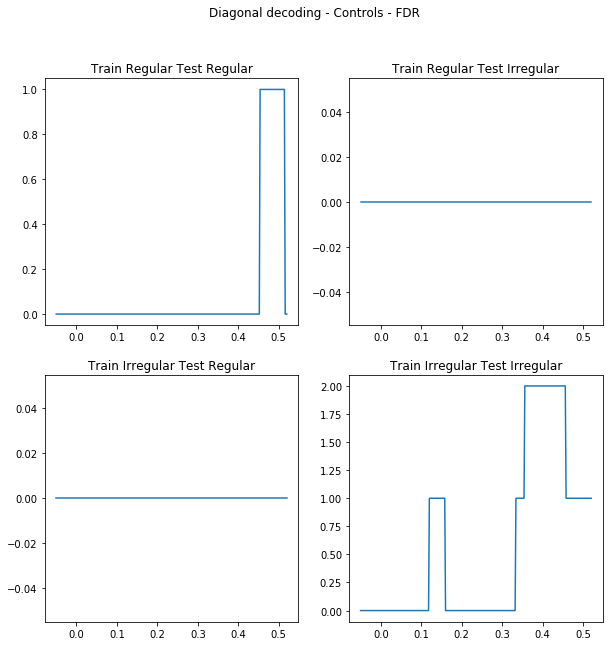

In [71]:
four_plots(timevec,subtitles,diag_sig_fdr_controls,'Controls - FDR')

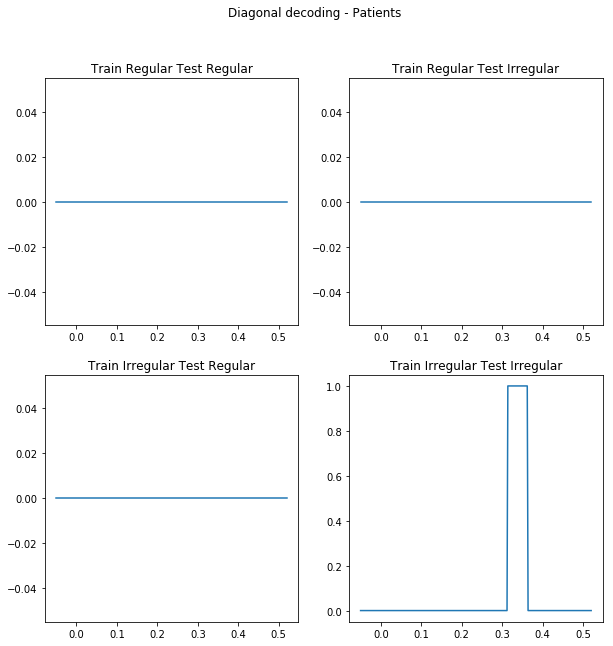

In [73]:
four_plots(timevec,subtitles,diag_sig_fdr_patients,'Patients')

Uncomment the following lines to look at the same counts without FDR correction

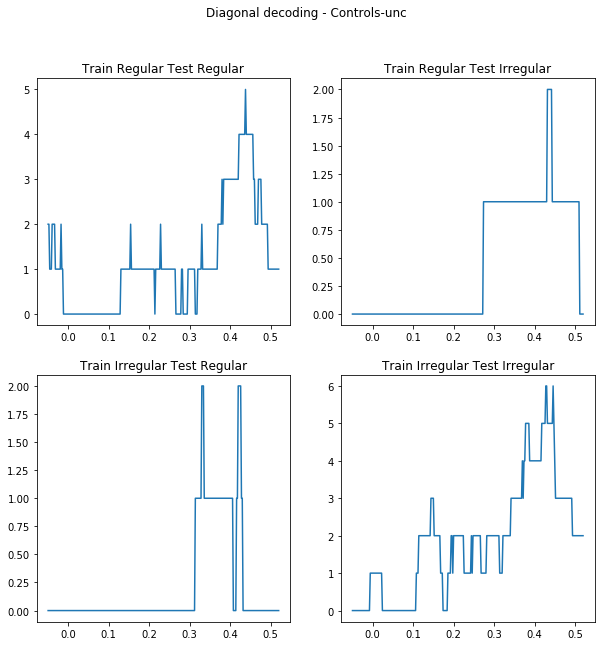

In [74]:
four_plots(timevec,subtitles,diag_sig_unc_controls,'Controls-unc')

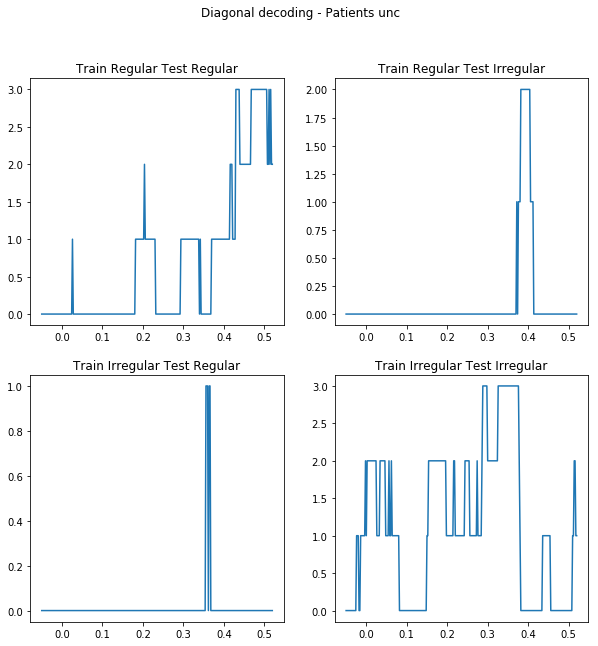

In [75]:
four_plots(timevec,subtitles,diag_sig_unc_patients,'Patients unc')


We can examine the ROC AUC scores for the same subjects, to check whether this phenomenon has anything to do with classification performance (it should!). For that, we overlay the FDR-corrected timewise significance of the Mann-Whitney U-test with the ROC AUC performance of the problematic subjects

Showing subjects with less than 40 FDR significant points
Subj 190201_beta_07k1_formal_conditionwise.npz has zero or few significant FDR : 0 


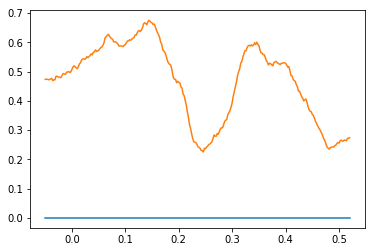

Subj 190201_beta_20k1_formal_conditionwise.npz has zero or few significant FDR : 0 


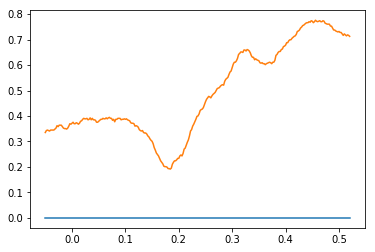

Subj 190201_beta_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 


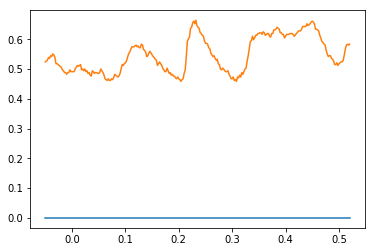

Subj 190201_beta_11k1_formal_conditionwise.npz has zero or few significant FDR : 31 


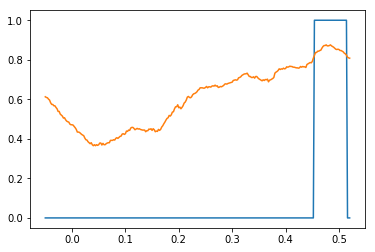

Subj 190201_beta_13k1_formal_conditionwise.npz has zero or few significant FDR : 0 


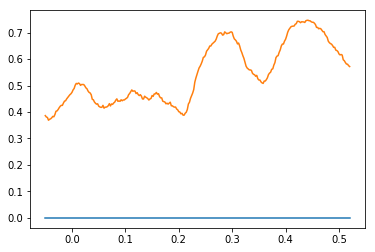

Subj 190201_beta_14k1_formal_conditionwise.npz has zero or few significant FDR : 0 


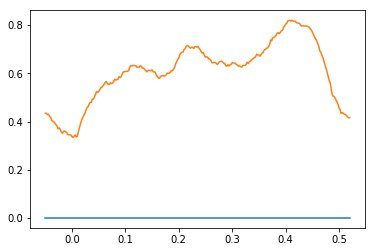

Subj 190201_beta_12k1_formal_conditionwise.npz has zero or few significant FDR : 0 


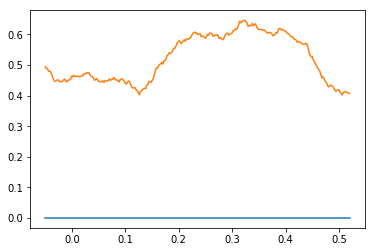

Subj 190201_beta_16k1_formal_conditionwise.npz has zero or few significant FDR : 0 


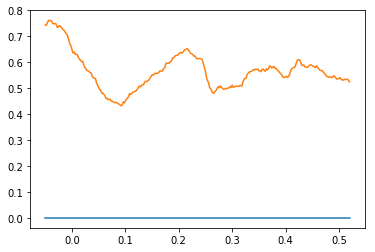

Subj 190201_beta_19k1_formal_conditionwise.npz has zero or few significant FDR : 0 


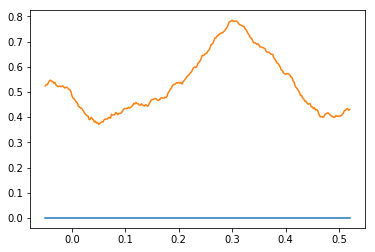

Subj 190201_beta_17k1_formal_conditionwise.npz has zero or few significant FDR : 0 


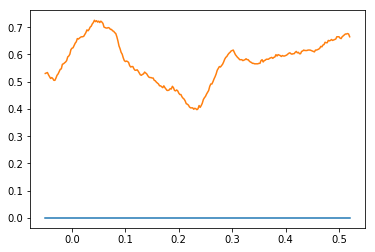

Subj 190201_beta_08k1_formal_conditionwise.npz has zero or few significant FDR : 0 


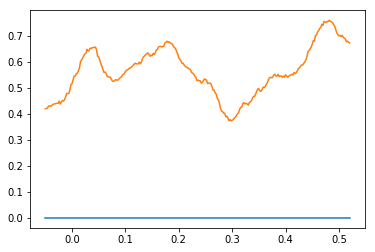

Subj 190201_beta_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 


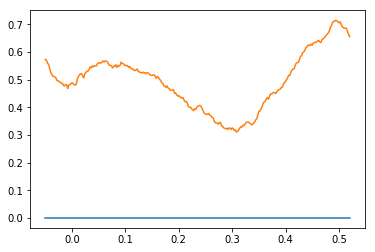

Subj 190201_beta_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 


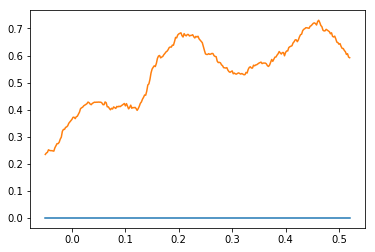

Subj 190201_beta_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 


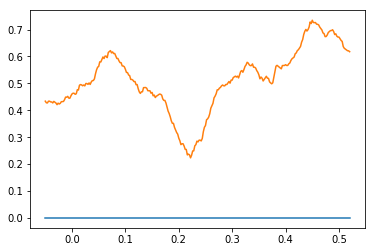

Subj 190201_beta_01k1_formal_conditionwise.npz has zero or few significant FDR : 0 


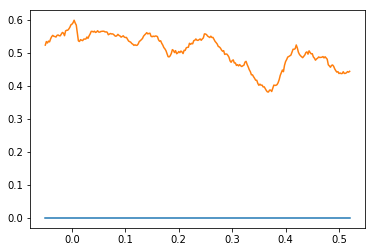

Subj 190201_beta_04k1_formal_conditionwise.npz has zero or few significant FDR : 0 


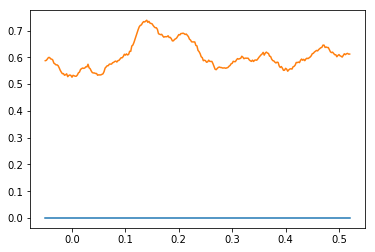

Subj 190201_beta_05k1_formal_conditionwise.npz has zero or few significant FDR : 0 


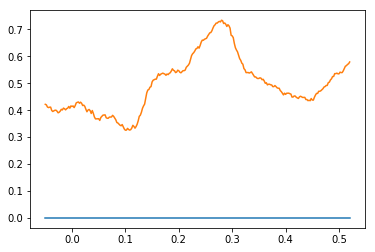

Subj 190201_beta_09k1_formal_conditionwise.npz has zero or few significant FDR : 0 


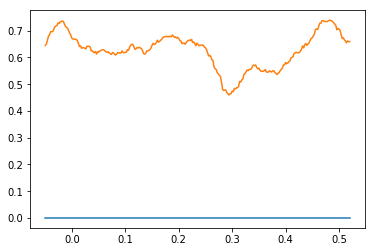

Showing subjects with less than 40 FDR significant points
Subj 190201_beta_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 


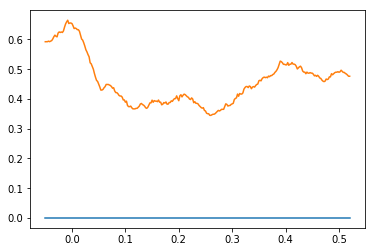

Subj 190201_beta_03c1_formal_conditionwise.npz has zero or few significant FDR : 0 


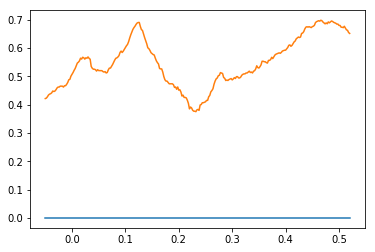

Subj 190201_beta_10c1_formal_conditionwise.npz has zero or few significant FDR : 0 


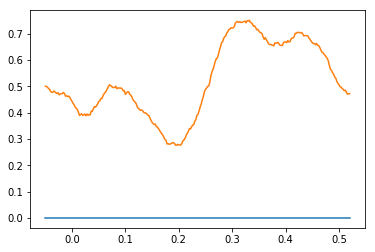

Subj 190201_beta_04c1_formal_conditionwise.npz has zero or few significant FDR : 0 


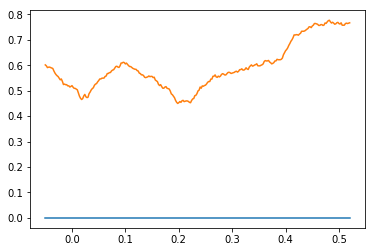

Subj 190201_beta_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 


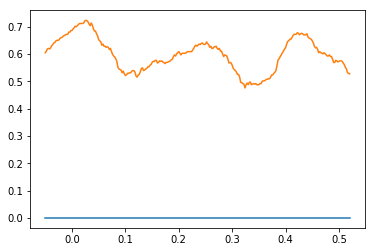

Subj 190201_beta_09c1_formal_conditionwise.npz has zero or few significant FDR : 0 


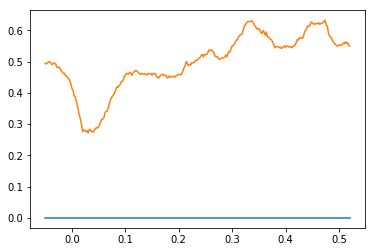

Subj 190201_beta_02c1_formal_conditionwise.npz has zero or few significant FDR : 0 


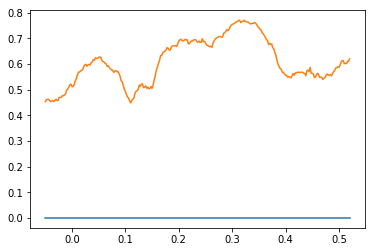

Subj 190201_beta_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 


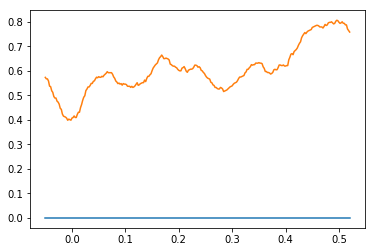

Subj 190201_beta_17c1_formal_conditionwise.npz has zero or few significant FDR : 0 


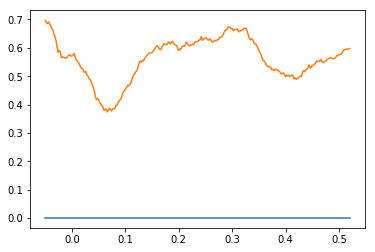

Subj 190201_beta_05c1_formal_conditionwise.npz has zero or few significant FDR : 25 


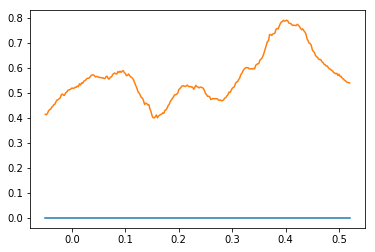

Subj 190201_beta_06c1_formal_conditionwise.npz has zero or few significant FDR : 0 


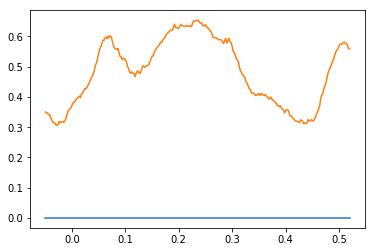

Subj 190201_beta_13c1_formal_conditionwise.npz has zero or few significant FDR : 0 


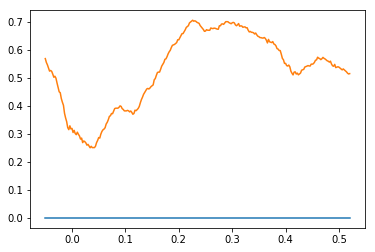

Subj 190201_beta_07c1_formal_conditionwise.npz has zero or few significant FDR : 0 


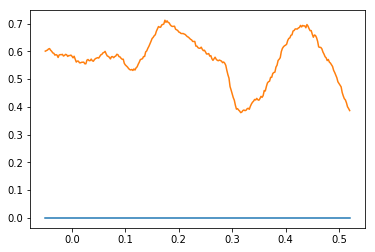

Subj 190201_beta_01c1_formal_conditionwise.npz has zero or few significant FDR : 0 


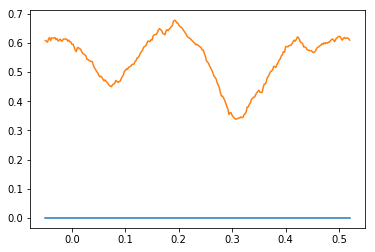

Subj 190201_beta_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 


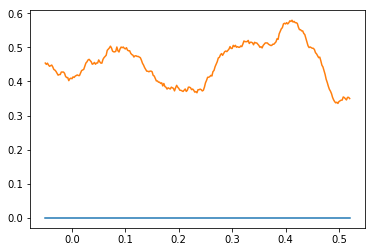

Subj 190201_beta_08c1_formal_conditionwise.npz has zero or few significant FDR : 0 


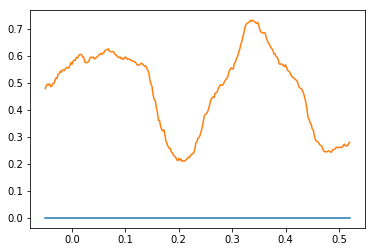

In [77]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,timevec=timevec,doplots=True)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,timevec=timevec,doplots=True)

UPDATED - OCT 16th
--
Boosting the SNR actually has a very clear effect on ROC AUC, we now have scores around 0.8 in the 200 to 300 ms time window, even for subjects for which the Mann Whittney U-test didn't pass. 

To illustrate this at the group level, let's now plot the average and std of ROC AUC for the whole groups. 

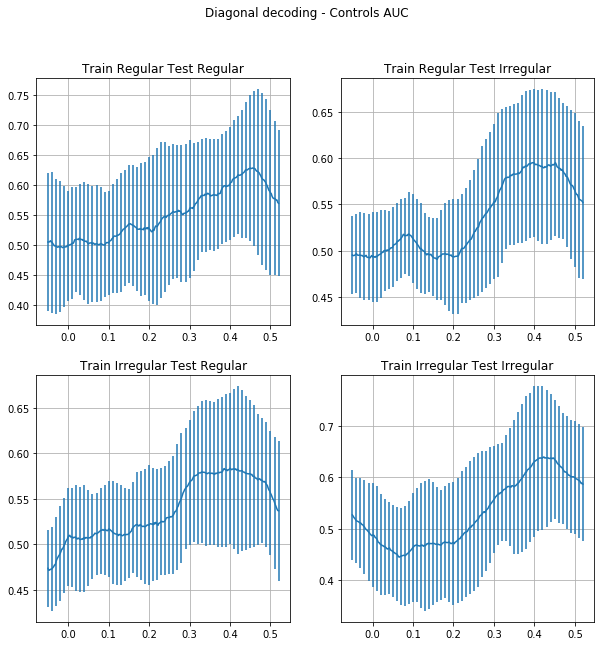

In [78]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')

We can deduce from this plot that for the control group, the time window between 200 and 250 ms seem to yield the most significant decoding across controls. This can be seen on the "Train Regular, Test Regular" condition, as well as the "train irregular, test irregular" condition, which are the two cases for which the classifier was trained. The other cases correspond to how well the classifier generalizes across conditions. We will test this aspect later in the report. 

For patients :

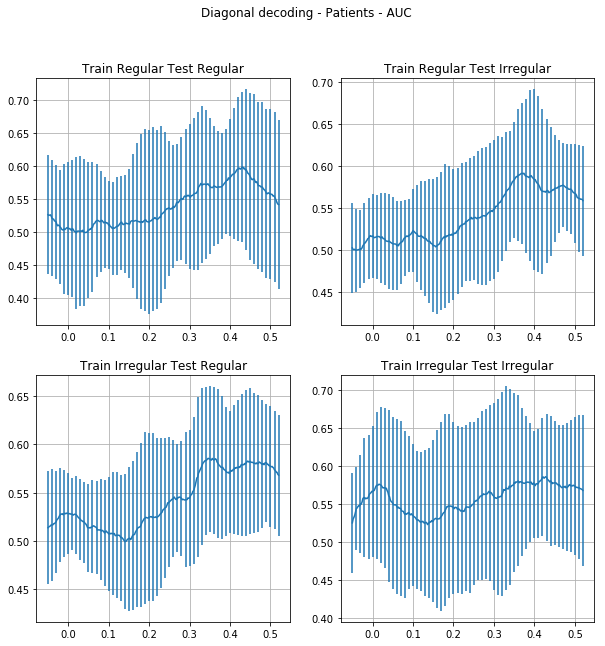

In [79]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')


Remember that 10 patients didn't have any significant classification, which explains the very high variability here. 

Let's see what happens on ROC if we don't include the data for which there is few FDR individual significance of Mann Whitnney. The next cell gathers all subjects data by rejecting subjects who don't pass the FDR significance with at least 40 points

In [80]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False,keepall=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False,keepall=False)

Showing subjects with less than 40 FDR significant points
Subj 190201_beta_07k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_20k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_11k1_formal_conditionwise.npz has zero or few significant FDR : 31 
Subj 190201_beta_13k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_14k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_12k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_16k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_19k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_17k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_08k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_

ValueError: need at least one array to stack

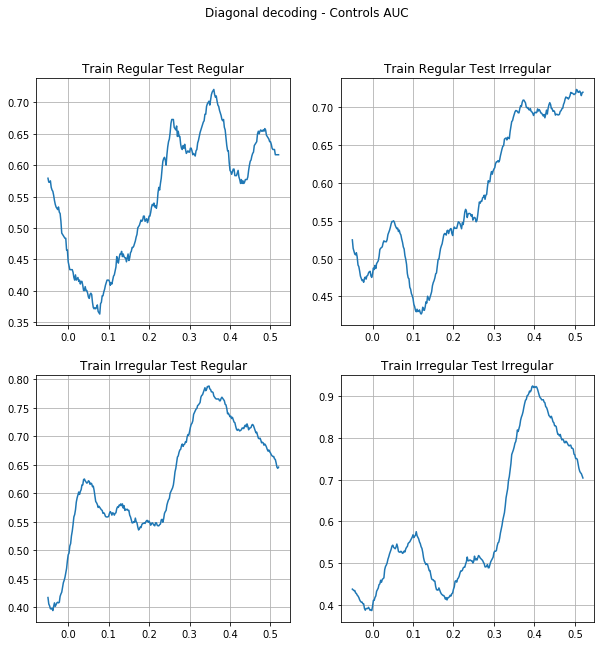

In [24]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')

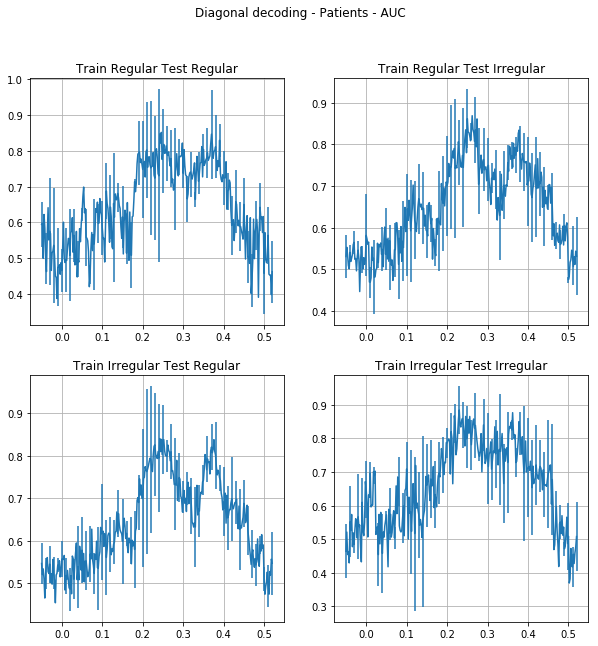

In [30]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')

Let's have a look at the averages only, but superimposing patients and controls on the same plots, zooming in on the region 200ms to 400 ms. 

We will superimpose the result of an independent t-test at each time point, between groups

In [31]:
from scipy.stats import ttest_ind

def twogroups_fourplots(timevec,subtitles,diag_roc1,diag_roc2,mytitle,tstart=None,tend=None,ttest=False):
    plt.figure(figsize=(10,10))

    ngroup1 = diag_roc1.shape[0]
    ngroup2 = diag_roc2.shape[0]
    
    if tstart is None:
        tstart=0
    if tend is None:
        tend=timevec.shape[0]
    
    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec[tstart:tend],diag_roc1[:,i-1,tstart:tend].mean(axis=0))
        plt.plot(timevec[tstart:tend],diag_roc2[:,i-1,tstart:tend].mean(axis=0))
        
        if ttest:
            
            
            tstat,p_unc = ttest_ind(a=diag_roc1[:,i-1,tstart:tend],b=diag_roc2[:,i-1,tstart:tend],equal_var=True)
            
            timevec_sub = timevec[tstart:tend]
            H = (p_unc<0.05)
            sig_ind = timevec_sub[H]
            sig= np.ones_like(sig_ind)*0.9
            
            #FDR correction            
            #H,p_fdr,_,_=multitest.multipletests(p_unc,method='fdr_bh')
            
            plt.plot(sig_ind,sig,'*')
            
            
        plt.title(subtitles[i-1])
        plt.grid(True)
    plt.legend(['controls (n=%d)' % ngroup1,'patients (n=%d)' % ngroup2,'ttest uncorr.'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

this is for only the "good" participants (high SnR) 

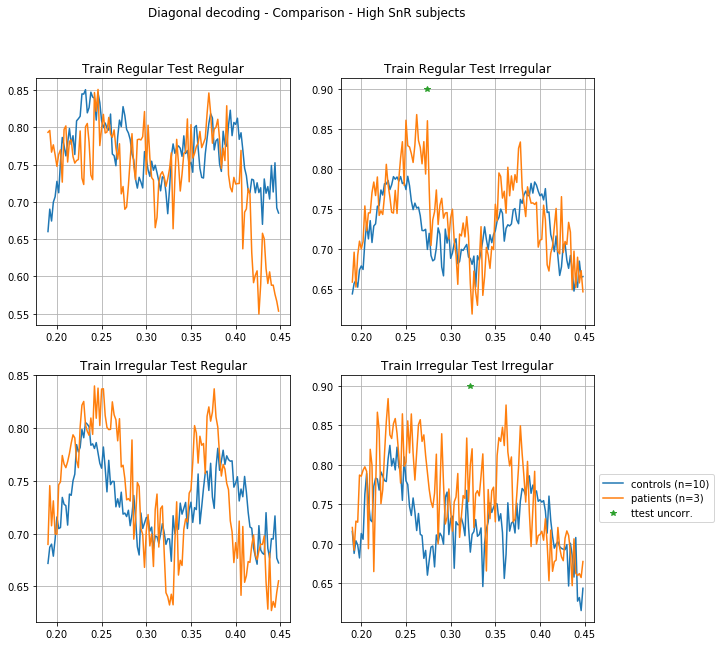

In [32]:
twogroups_fourplots(timevec,subtitles,diag_ROC_controls,diag_ROC_patients,'Comparison - High SnR subjects',tstart=120,tend=250,ttest=True)

and this is for all participants 

Showing subjects with less than 40 FDR significant points
Subj 190201_beta_07k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_11k1_formal_conditionwise.npz has zero or few significant FDR : 30 
Subj 190201_beta_03k1_formal_conditionwise.npz has zero or few significant FDR : 29 
Subj 190201_beta_19k1_formal_conditionwise.npz has zero or few significant FDR : 38 
Subj 190201_beta_17k1_formal_conditionwise.npz has zero or few significant FDR : 3 
Subj 190201_beta_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Showing subjects with less than 40 FDR significant points
Subj 190201_beta_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 190201_beta_04c1_formal_conditionwis

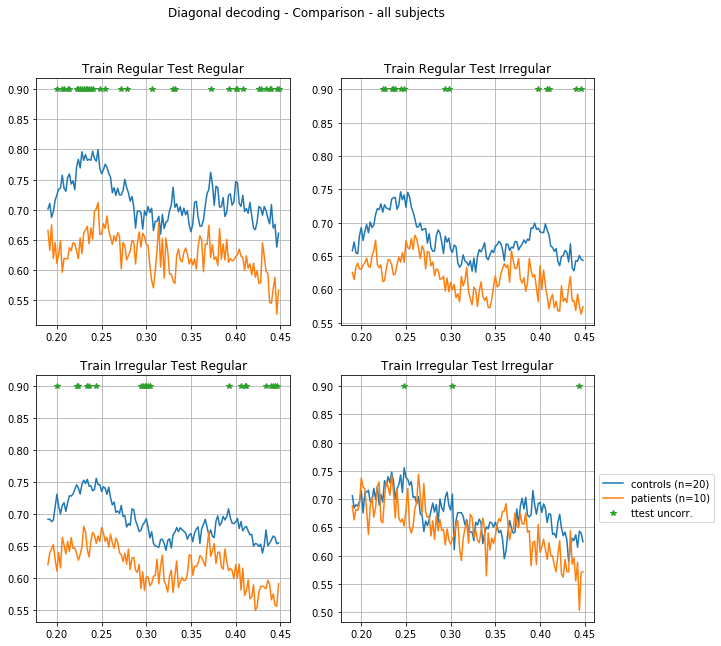

In [33]:
_,_,diag_ROC_controls_all = diagonal_group(controls_id,statspath,0.05,doplots=False,keepall=True)
_,_,diag_ROC_patients_all = diagonal_group(patients_id,statspath,0.05,doplots=False,keepall=True)
twogroups_fourplots(timevec,subtitles,diag_ROC_controls_all,diag_ROC_patients_all,'Comparison - all subjects',tstart=120,tend=250,ttest=True)

END OF UPDATED DATA WITH AVERAGED TRIALS (following parts where not updated yet) 
--

Within-subject statistics of condition comparison
--

Between-subject statistics of estimated class probabilities
--

In [26]:
from scipy.stats import wilcoxon

In [27]:
wilcoxon?

In [28]:
def betweensubjects_diag(subjlist,statspath):
    
    wilcox_Z_all = []
    wilcox_p_all = []
    
    proba_std_all = []
    proba_dev_all = []
    
    H_all = []

    wilcox_pfdr_all = []
    
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curproba = np.load(cursubj)['proba'].mean(axis=1)
        
        diag_proba_std = np.stack([np.diag(curmat) for curmat in curproba[:,0]]) # extract diagonal classification
        diag_proba_dev = np.stack([np.diag(curmat) for curmat in curproba[:,1]]) # extract diagonal classification
        
        proba_std_all.append(diag_proba_std)
        proba_dev_all.append(diag_proba_dev)
            
    proba_std_all = np.stack(proba_std_all)
    proba_dev_all = np.stack(proba_dev_all)
    
    
    nsub,nrep,ntime = proba_std_all.shape
    
    
    for i in range(nrep):
        p_rep = []
        for j in range(ntime):
            z,p = wilcoxon(x=proba_std_all[:,i,j].ravel(),y=proba_dev_all[:,i,j].ravel())
            
            wilcox_Z_all.append(z)
            p_rep.append(p)
            
        p_rep = np.stack(p_rep)
        
        wilcox_p_all.append(p_rep)
        
        H,pfdr,_,_=multitest.multipletests(p_rep,method='fdr_bh')
        
        H_all.append(H)
        wilcox_pfdr_all.append(pfdr)
        
    #print(proba_all.shape)
    
    return np.reshape(np.stack(wilcox_Z_all),(nrep,ntime)),np.reshape(np.stack(wilcox_p_all),(nrep,ntime)),np.reshape(np.stack(wilcox_pfdr_all),(nrep,ntime)),np.reshape(np.stack(H_all),(nrep,ntime))

In [29]:
allZ_controls, all_Punc_controls,all_Pfdr_controls,wilcox_H_controls = betweensubjects_diag(controls_id,statspath)
allZ_patients, all_Punc_patients,all_Pfdr_patients,wilcox_H_patients = betweensubjects_diag(patients_id,statspath)

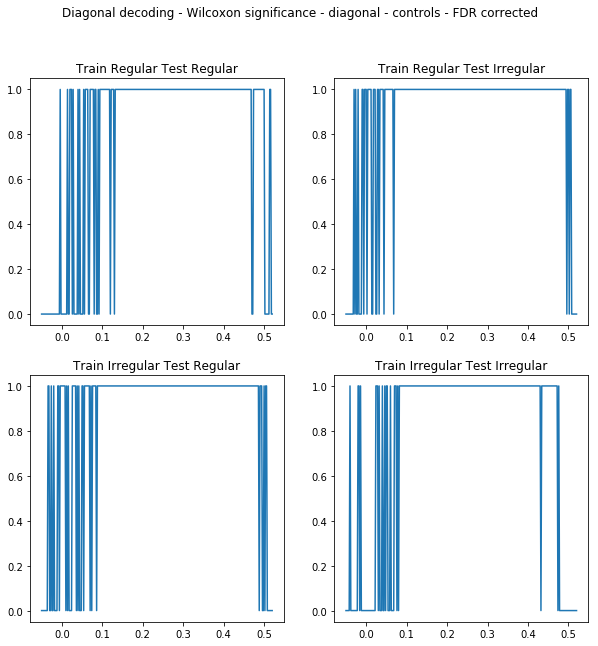

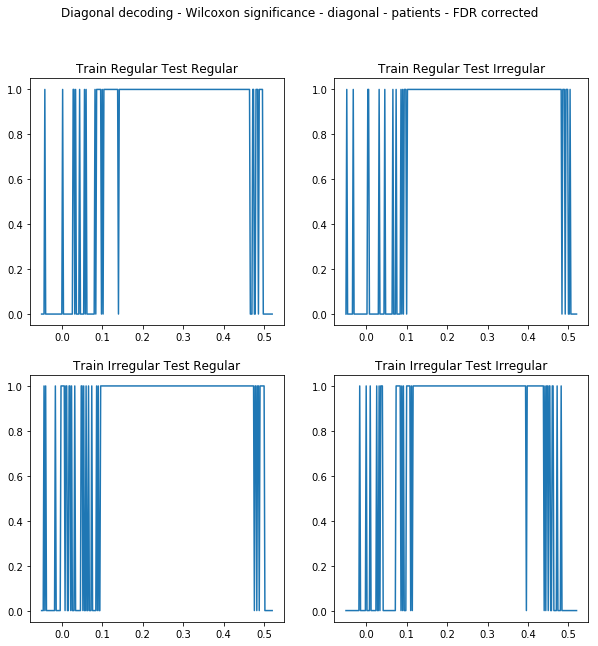

In [30]:
four_plots(timevec,subtitles,wilcox_H_controls,'Wilcoxon significance - diagonal - controls - FDR corrected')
four_plots(timevec,subtitles,wilcox_H_patients,'Wilcoxon significance - diagonal - patients - FDR corrected')

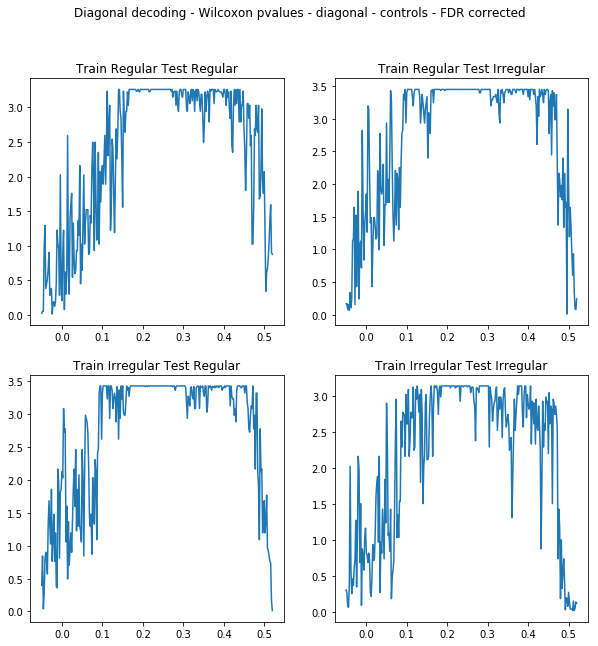

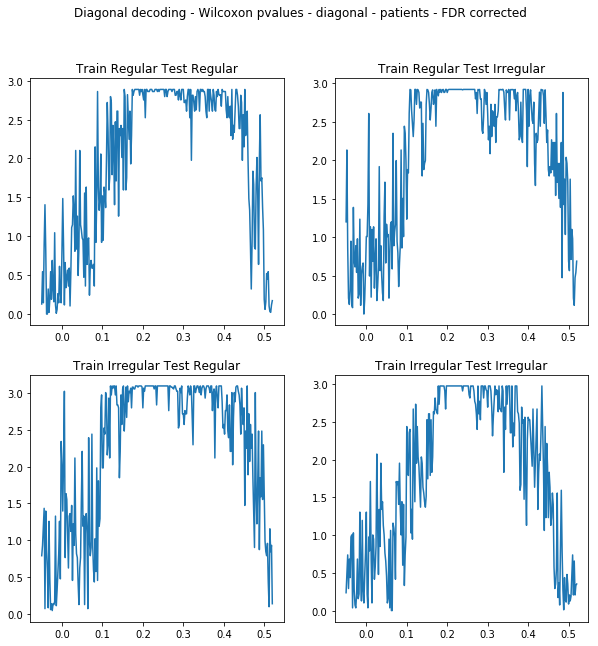

In [31]:
four_plots(timevec,subtitles,-np.log10(all_Pfdr_controls),'Wilcoxon pvalues - diagonal - controls - FDR corrected')
four_plots(timevec,subtitles,-np.log10(all_Pfdr_patients),'Wilcoxon pvalues - diagonal - patients - FDR corrected')

Analysis of Temporal Generalization
--

In order to analyze temporal generalization we need to define a window in which diagonal decoding is significant. Based on previous analysis on the "high snr subjects", we can reasonably work in the 200 to 300 ms window, and test whether the scalp patterns obtained in this window generalize to other time points. 

In [32]:
def offdiagonal_group(subjlist,statspath,timepoint,thresh_unc = 0.01,timevec=None,showall=False,threshold_zeros=40,doplots=True,keepall=True):

    if (showall):
        print("Showing all subjects")
    else:
        print("Showing subjects with less than %d FDR significant points" % threshold_zeros)
    
    odiag_sig_fdr_all = []
    odiag_sig_unc_all = []
    odiag_ROC_all = []
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores'].mean(axis=1)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        
        offdiag_pvals = np.stack([curmat[timepoint,:] for curmat in curpvals]) # extract a line from the matrix

        odiag_ROC = np.stack([curmat[timepoint,:] for curmat in curroc]) # extract a line from the matrix
                
        odiag_sig_fdr = []
        odiag_sig_unc = []
        for curdiag in offdiag_pvals:
            H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
            H_unc = curdiag < thresh_unc
            odiag_sig_unc.append(H_unc)
            odiag_sig_fdr.append(H)

        nonzeros = np.sum(np.stack(odiag_sig_fdr))
        if showall:
            print("Subj %s number of non-zeros FDR : %d " %(subj,nonzeros))
                        
        elif nonzeros < threshold_zeros:
            print("Subj %s has zero or few significant FDR : %d " %(subj,nonzeros))
            
            if (nonzeros >= 0 ) and doplots:
                #plt.subplot(1,2,1)
                plt.plot(timevec,odiag_sig_fdr[0])
                #plt.subplot(1,2,2)
                plt.plot(timevec,odiag_ROC[0])
                plt.show()
            
        
        #print("Subj %s number of non-zeros Uncorrected : %d " %(subj,np.sum(np.stack(diag_sig_unc))))
        
        if (nonzeros > threshold_zeros) or keepall:
            odiag_sig_fdr_all.append(np.stack(odiag_sig_fdr))
            odiag_sig_unc_all.append(np.stack(odiag_sig_unc))
            odiag_ROC_all.append(odiag_ROC)

    
    return np.sum(np.stack(odiag_sig_fdr_all),axis=0),np.sum(np.stack(odiag_sig_unc_all),axis=0),np.stack(odiag_ROC_all)

In [33]:
tp=0.200
tp_ind = 125
### Find the index corresponding to this timepoint 
print(timevec[tp_ind])

0.2


In [34]:
tp_ind2 = 175
### Find the index corresponding to this timepoint 
print(timevec[tp_ind2])

0.30000000000000004


Showing subjects with less than 40 FDR significant points
Subj 181016_09k1_formal_conditionwise.npz has zero or few significant FDR : 0 


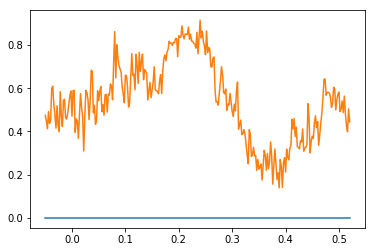

Subj 181016_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 


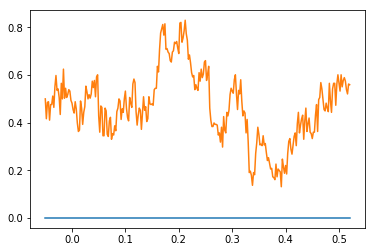

Subj 181016_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 


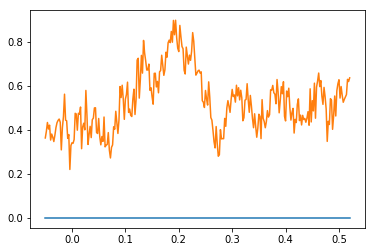

Subj 181016_05k1_formal_conditionwise.npz has zero or few significant FDR : 0 


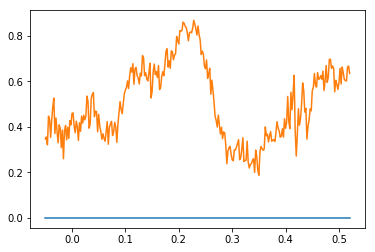

Subj 181016_11k1_formal_conditionwise.npz has zero or few significant FDR : 0 


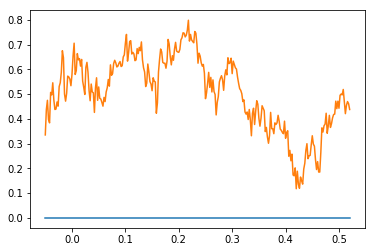

Subj 181016_12k1_formal_conditionwise.npz has zero or few significant FDR : 25 


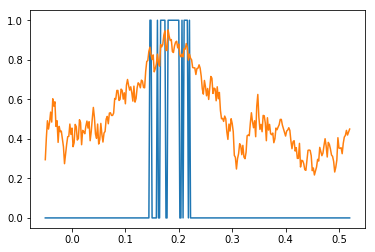

Subj 181016_08k1_formal_conditionwise.npz has zero or few significant FDR : 0 


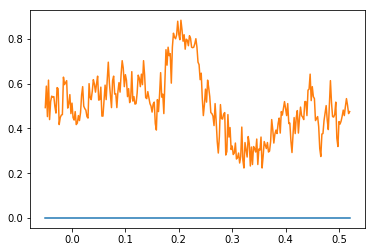

Subj 181016_07k1_formal_conditionwise.npz has zero or few significant FDR : 0 


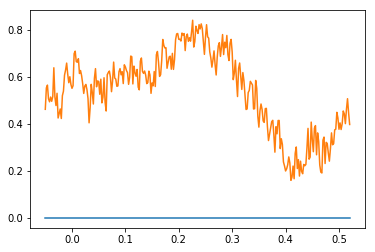

Subj 181016_17k1_formal_conditionwise.npz has zero or few significant FDR : 0 


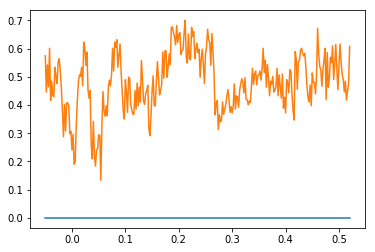

Subj 181016_10k1_formal_conditionwise.npz has zero or few significant FDR : 3 


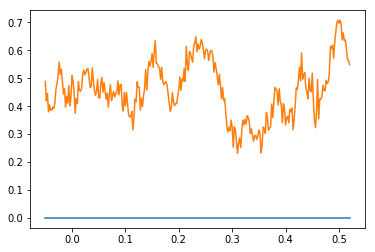

Subj 181016_19k1_formal_conditionwise.npz has zero or few significant FDR : 35 


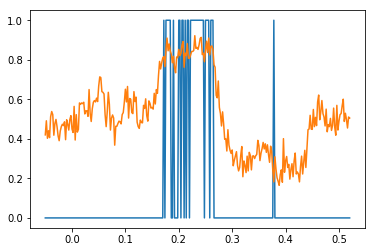

Subj 181016_20k1_formal_conditionwise.npz has zero or few significant FDR : 0 


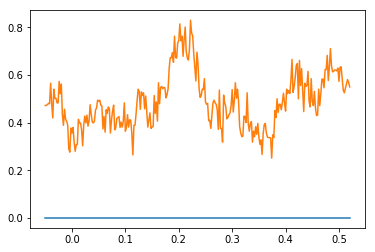

Subj 181016_03k1_formal_conditionwise.npz has zero or few significant FDR : 0 


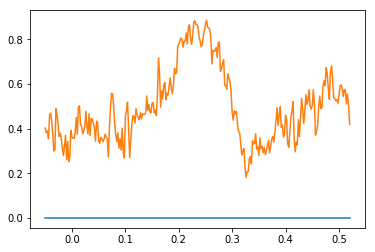

Subj 181016_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 


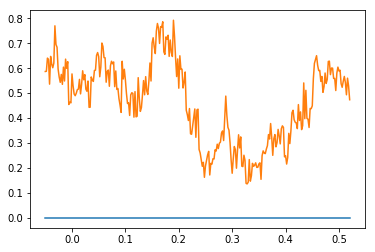

Subj 181016_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 


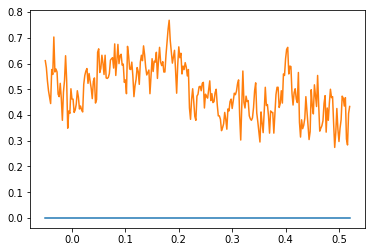

Subj 181016_16k1_formal_conditionwise.npz has zero or few significant FDR : 0 


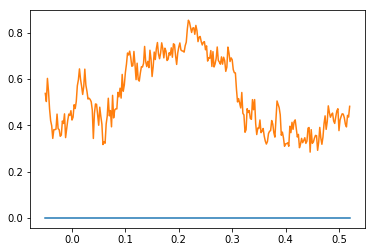

Subj 181016_14k1_formal_conditionwise.npz has zero or few significant FDR : 0 


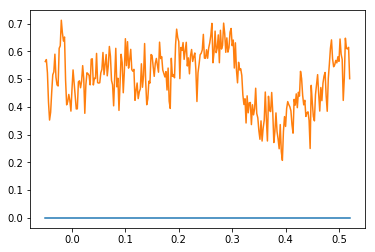

Showing subjects with less than 40 FDR significant points
Subj 181016_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 


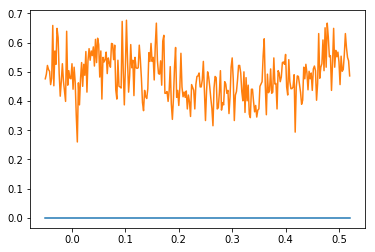

Subj 181016_17c1_formal_conditionwise.npz has zero or few significant FDR : 0 


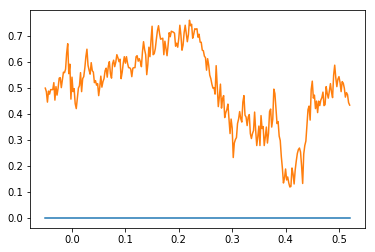

Subj 181016_01m1_formal_conditionwise.npz has zero or few significant FDR : 0 


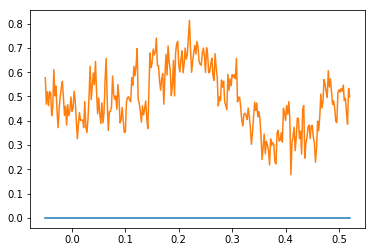

Subj 181016_09c1_formal_conditionwise.npz has zero or few significant FDR : 0 


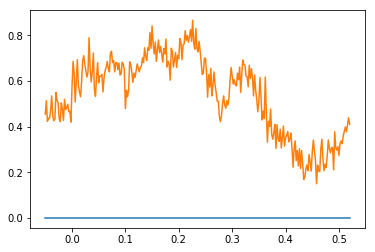

Subj 181016_06c1_formal_conditionwise.npz has zero or few significant FDR : 0 


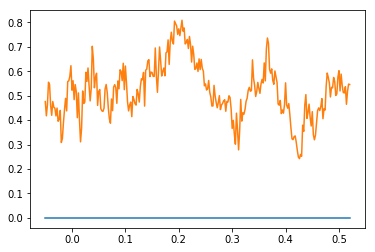

Subj 181016_02m1_formal_conditionwise.npz has zero or few significant FDR : 0 


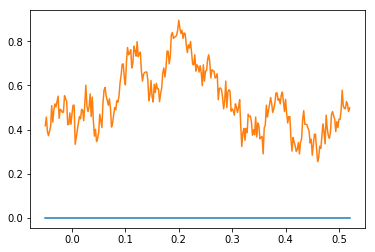

Subj 181016_04m1_formal_conditionwise.npz has zero or few significant FDR : 0 


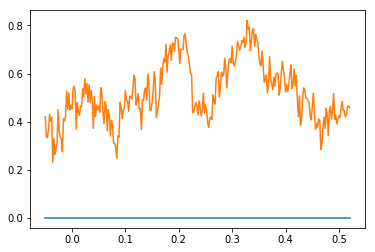

Subj 181016_08c1_formal_conditionwise.npz has zero or few significant FDR : 0 


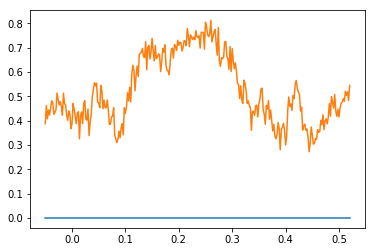

Subj 181016_13c1_formal_conditionwise.npz has zero or few significant FDR : 0 


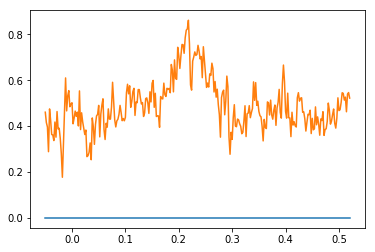

Subj 181016_02c1_formal_conditionwise.npz has zero or few significant FDR : 0 


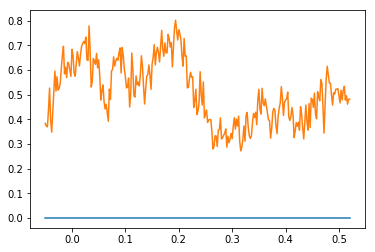

Subj 181016_01c1_formal_conditionwise.npz has zero or few significant FDR : 0 


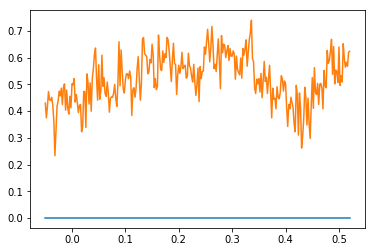

Subj 181016_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 


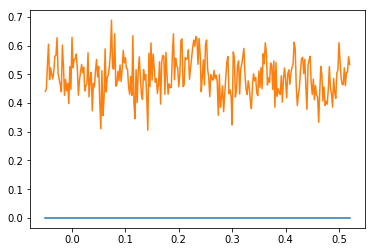

Subj 181016_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 


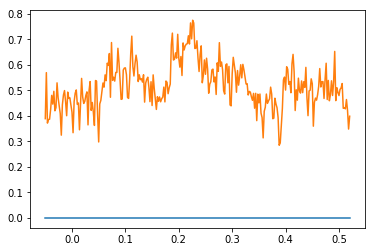

Subj 181016_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 


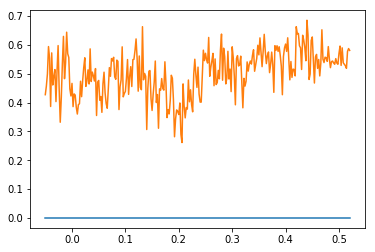

Subj 181016_04c1_formal_conditionwise.npz has zero or few significant FDR : 0 


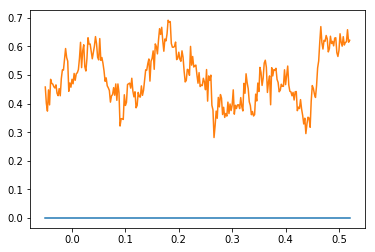

Subj 181016_07c1_formal_conditionwise.npz has zero or few significant FDR : 31 


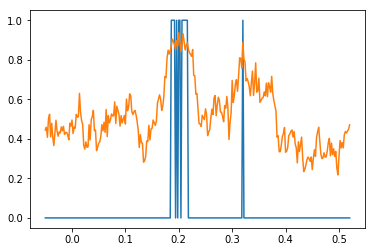

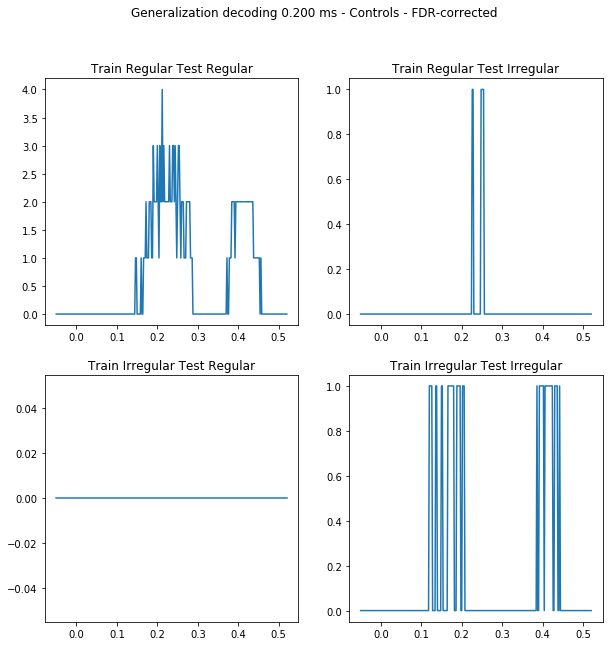

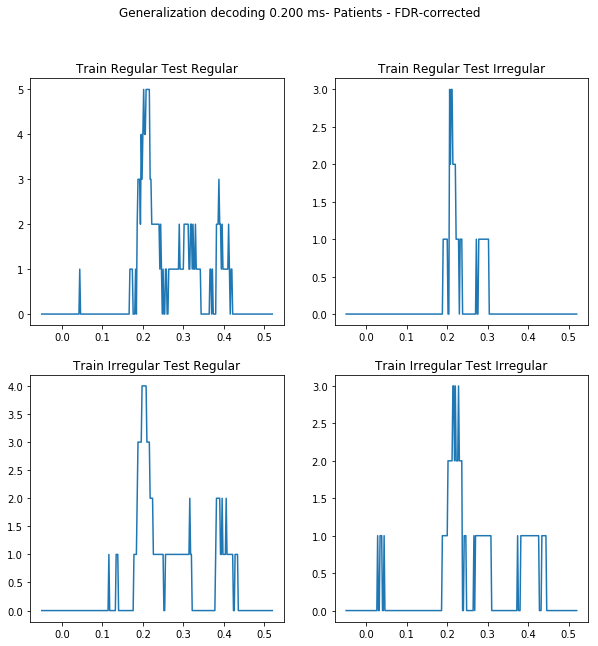

Showing subjects with less than 40 FDR significant points
Subj 181016_09k1_formal_conditionwise.npz has zero or few significant FDR : 0 


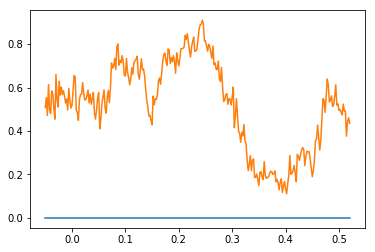

Subj 181016_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 


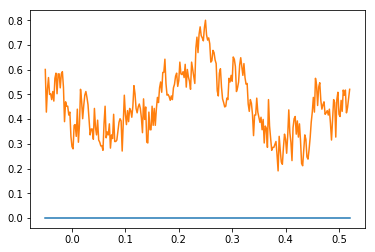

Subj 181016_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 


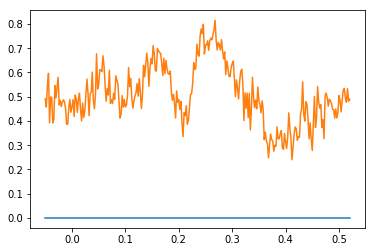

Subj 181016_05k1_formal_conditionwise.npz has zero or few significant FDR : 0 


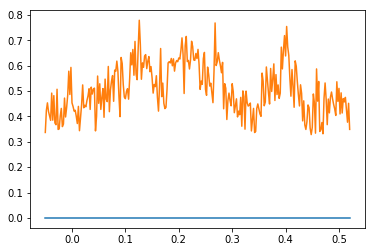

Subj 181016_11k1_formal_conditionwise.npz has zero or few significant FDR : 0 


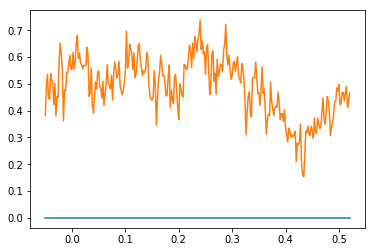

Subj 181016_12k1_formal_conditionwise.npz has zero or few significant FDR : 0 


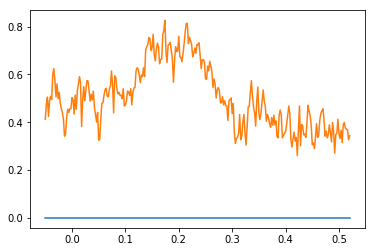

Subj 181016_08k1_formal_conditionwise.npz has zero or few significant FDR : 0 


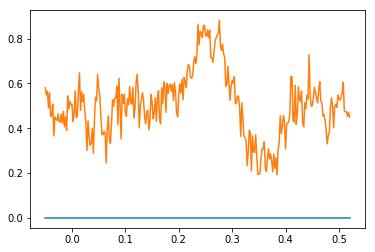

Subj 181016_07k1_formal_conditionwise.npz has zero or few significant FDR : 0 


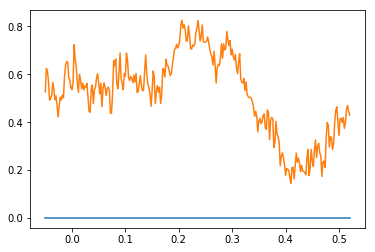

Subj 181016_04k1_formal_conditionwise.npz has zero or few significant FDR : 0 


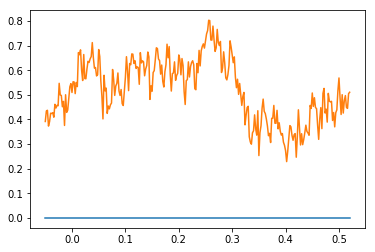

Subj 181016_17k1_formal_conditionwise.npz has zero or few significant FDR : 0 


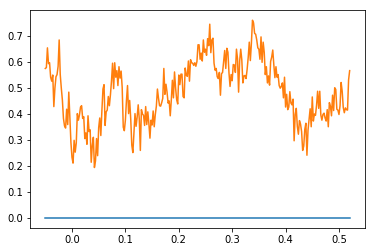

Subj 181016_10k1_formal_conditionwise.npz has zero or few significant FDR : 1 


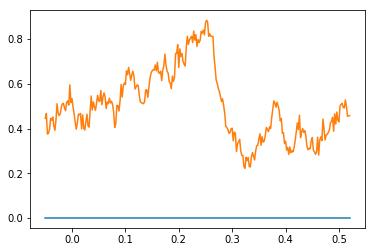

Subj 181016_19k1_formal_conditionwise.npz has zero or few significant FDR : 0 


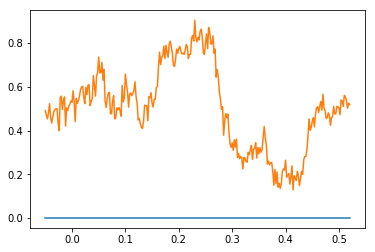

Subj 181016_03k1_formal_conditionwise.npz has zero or few significant FDR : 30 


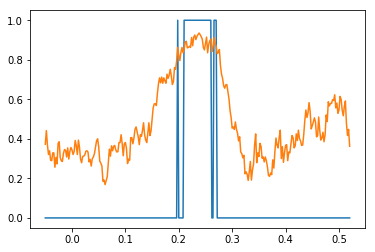

Subj 181016_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 


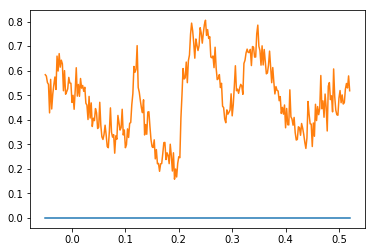

Subj 181016_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 


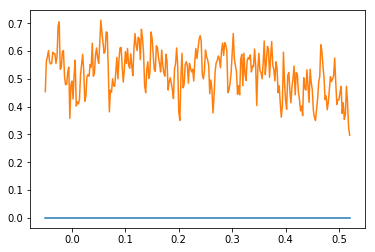

Subj 181016_16k1_formal_conditionwise.npz has zero or few significant FDR : 12 


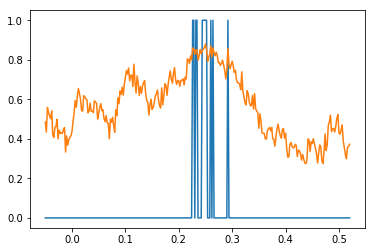

Subj 181016_14k1_formal_conditionwise.npz has zero or few significant FDR : 24 


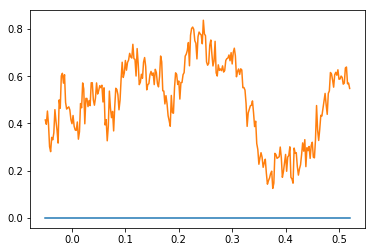

Showing subjects with less than 40 FDR significant points
Subj 181016_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 


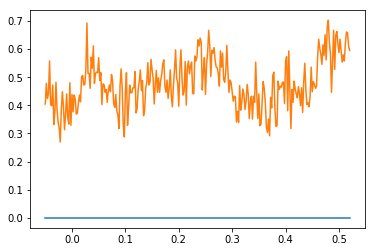

Subj 181016_17c1_formal_conditionwise.npz has zero or few significant FDR : 0 


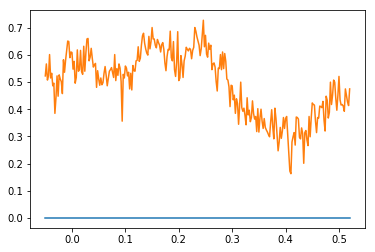

Subj 181016_01m1_formal_conditionwise.npz has zero or few significant FDR : 0 


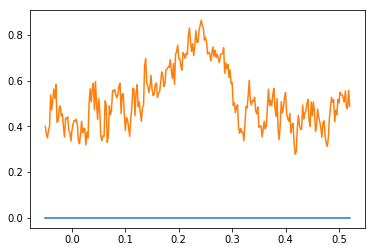

Subj 181016_09c1_formal_conditionwise.npz has zero or few significant FDR : 0 


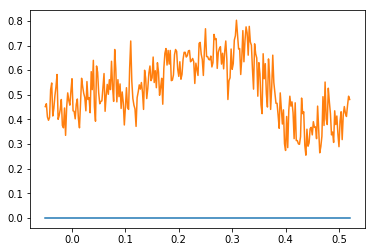

Subj 181016_02m1_formal_conditionwise.npz has zero or few significant FDR : 0 


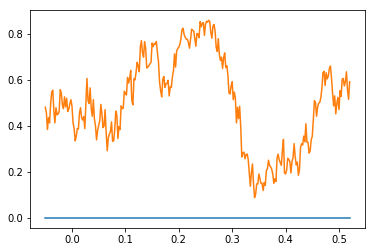

Subj 181016_04m1_formal_conditionwise.npz has zero or few significant FDR : 0 


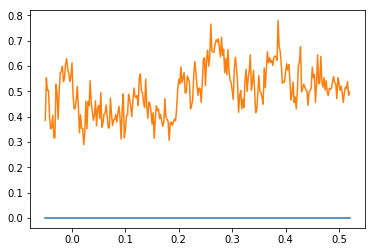

Subj 181016_08c1_formal_conditionwise.npz has zero or few significant FDR : 9 


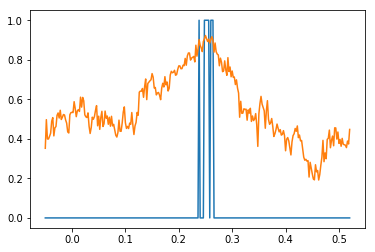

Subj 181016_13c1_formal_conditionwise.npz has zero or few significant FDR : 0 


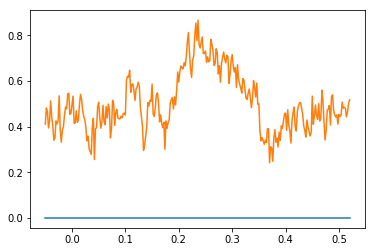

Subj 181016_02c1_formal_conditionwise.npz has zero or few significant FDR : 0 


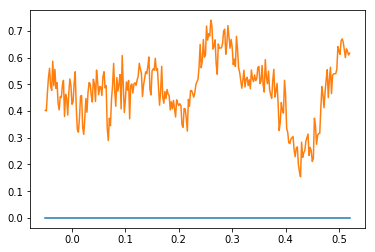

Subj 181016_01c1_formal_conditionwise.npz has zero or few significant FDR : 2 


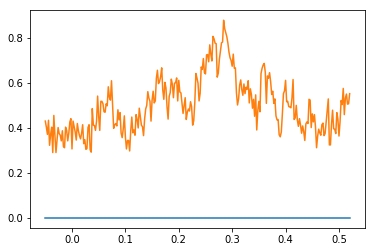

Subj 181016_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 


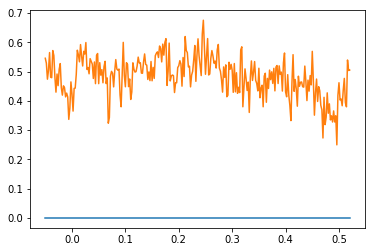

Subj 181016_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 


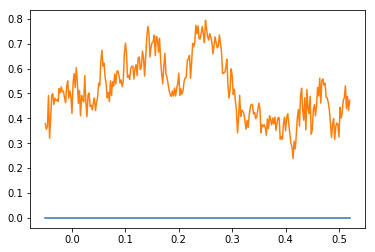

Subj 181016_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 


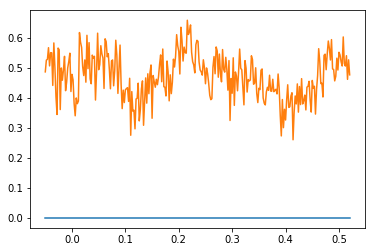

Subj 181016_04c1_formal_conditionwise.npz has zero or few significant FDR : 0 


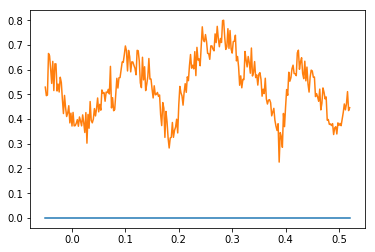

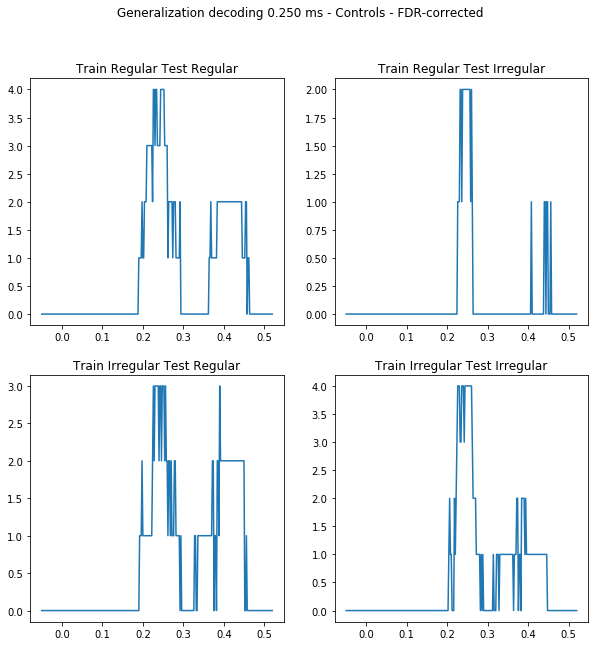

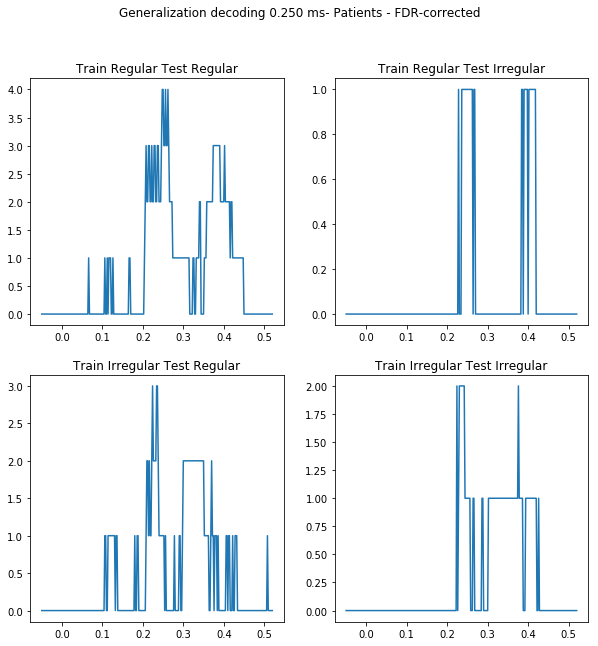

Showing subjects with less than 40 FDR significant points
Subj 181016_09k1_formal_conditionwise.npz has zero or few significant FDR : 0 


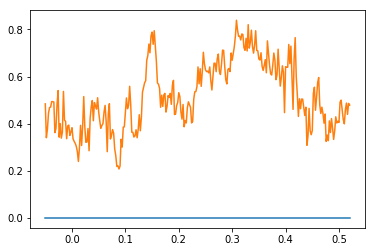

Subj 181016_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 


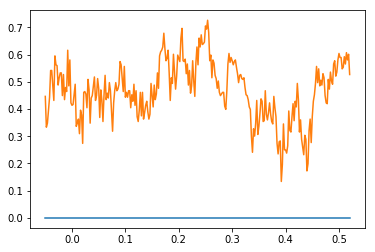

Subj 181016_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 


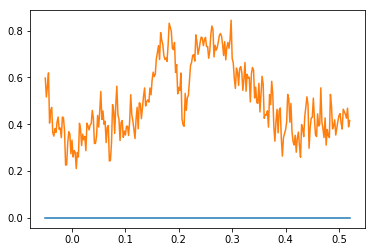

Subj 181016_05k1_formal_conditionwise.npz has zero or few significant FDR : 0 


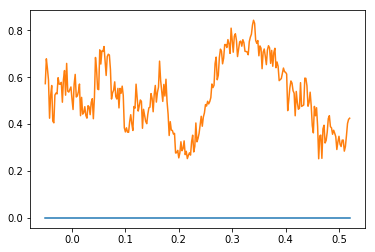

Subj 181016_11k1_formal_conditionwise.npz has zero or few significant FDR : 0 


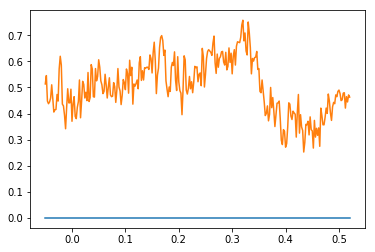

Subj 181016_12k1_formal_conditionwise.npz has zero or few significant FDR : 0 


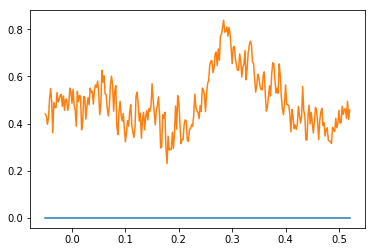

Subj 181016_08k1_formal_conditionwise.npz has zero or few significant FDR : 0 


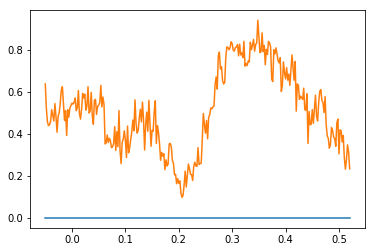

Subj 181016_07k1_formal_conditionwise.npz has zero or few significant FDR : 0 


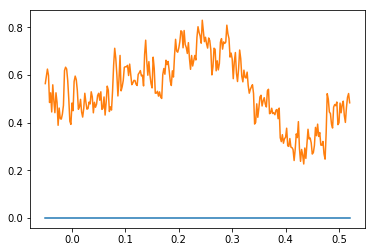

Subj 181016_04k1_formal_conditionwise.npz has zero or few significant FDR : 0 


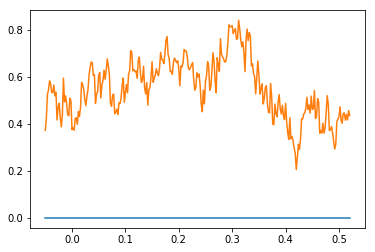

Subj 181016_17k1_formal_conditionwise.npz has zero or few significant FDR : 0 


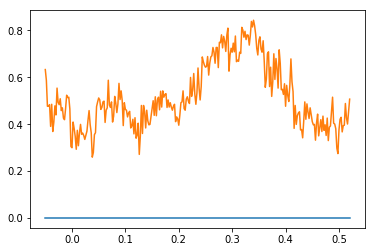

Subj 181016_10k1_formal_conditionwise.npz has zero or few significant FDR : 0 


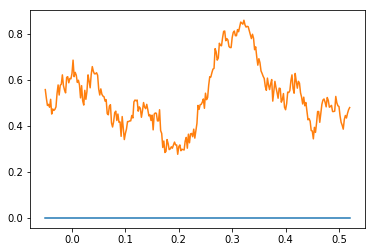

Subj 181016_19k1_formal_conditionwise.npz has zero or few significant FDR : 0 


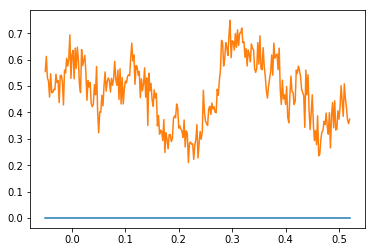

Subj 181016_20k1_formal_conditionwise.npz has zero or few significant FDR : 15 


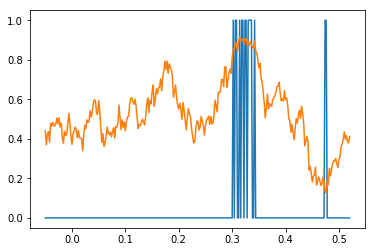

Subj 181016_03k1_formal_conditionwise.npz has zero or few significant FDR : 0 


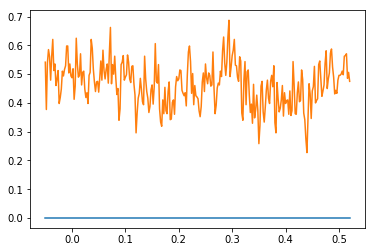

Subj 181016_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 


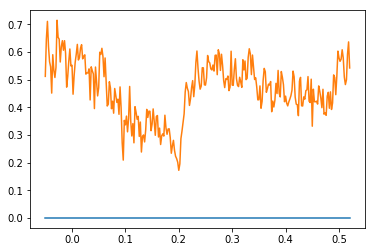

Subj 181016_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 


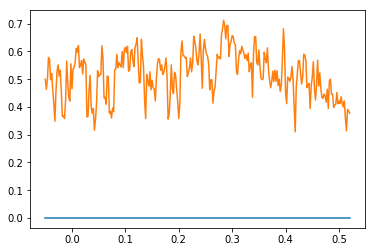

Subj 181016_01k1_formal_conditionwise.npz has zero or few significant FDR : 0 


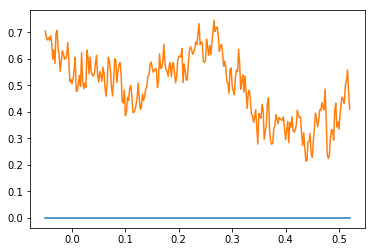

Subj 181016_14k1_formal_conditionwise.npz has zero or few significant FDR : 0 


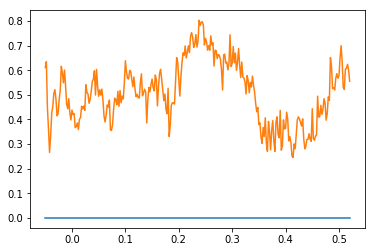

Showing subjects with less than 40 FDR significant points
Subj 181016_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 


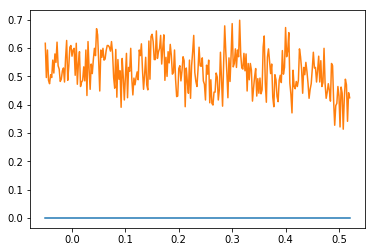

Subj 181016_17c1_formal_conditionwise.npz has zero or few significant FDR : 0 


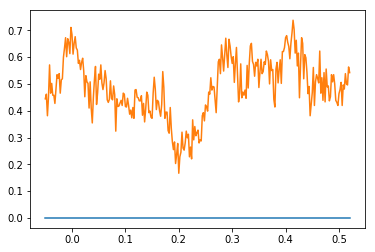

Subj 181016_01m1_formal_conditionwise.npz has zero or few significant FDR : 0 


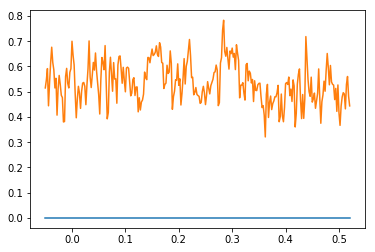

Subj 181016_03m1_formal_conditionwise.npz has zero or few significant FDR : 0 


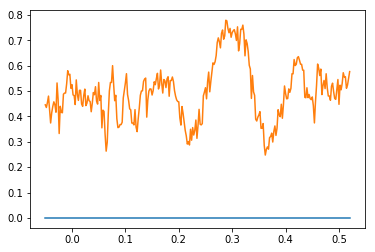

Subj 181016_09c1_formal_conditionwise.npz has zero or few significant FDR : 0 


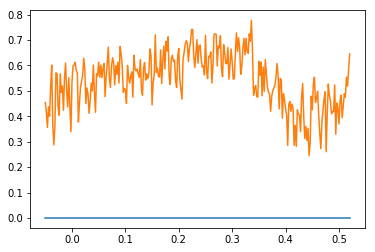

Subj 181016_06c1_formal_conditionwise.npz has zero or few significant FDR : 0 


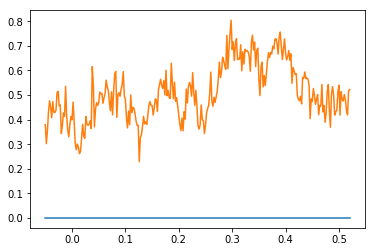

Subj 181016_02m1_formal_conditionwise.npz has zero or few significant FDR : 0 


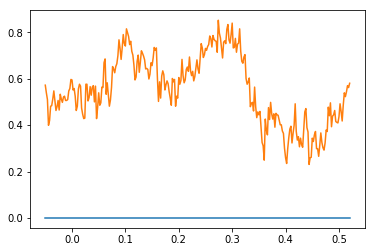

Subj 181016_04m1_formal_conditionwise.npz has zero or few significant FDR : 0 


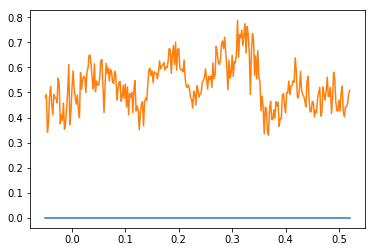

Subj 181016_08c1_formal_conditionwise.npz has zero or few significant FDR : 0 


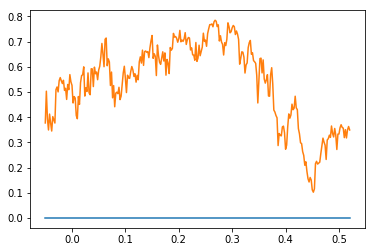

Subj 181016_13c1_formal_conditionwise.npz has zero or few significant FDR : 30 


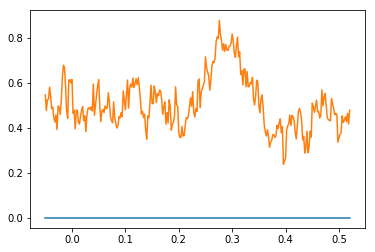

Subj 181016_02c1_formal_conditionwise.npz has zero or few significant FDR : 0 


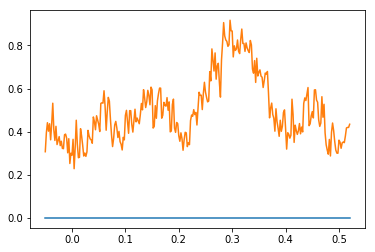

Subj 181016_01c1_formal_conditionwise.npz has zero or few significant FDR : 7 


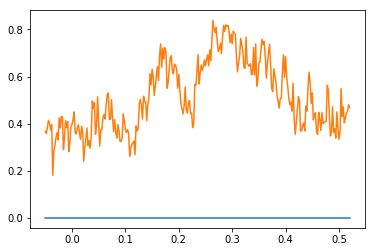

Subj 181016_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 


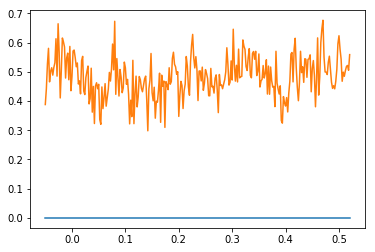

Subj 181016_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 


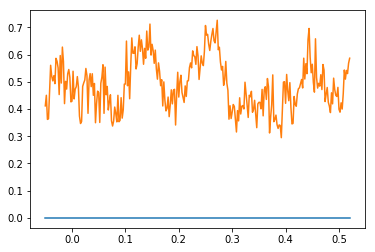

Subj 181016_05c1_formal_conditionwise.npz has zero or few significant FDR : 0 


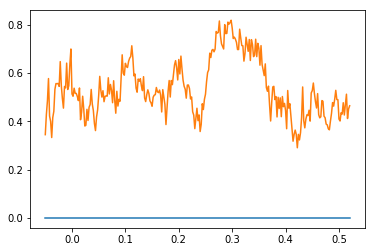

Subj 181016_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 


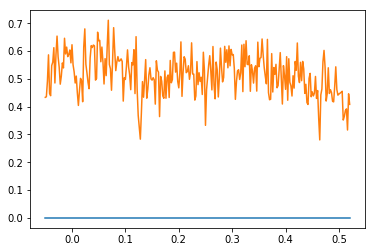

Subj 181016_04c1_formal_conditionwise.npz has zero or few significant FDR : 0 


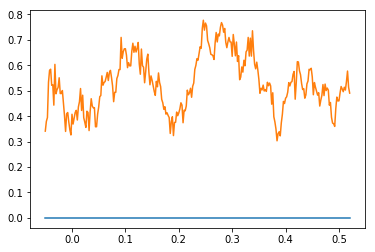

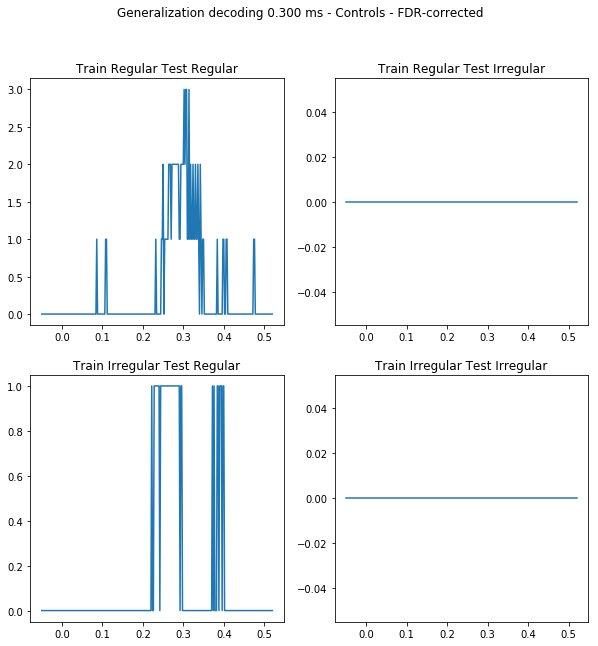

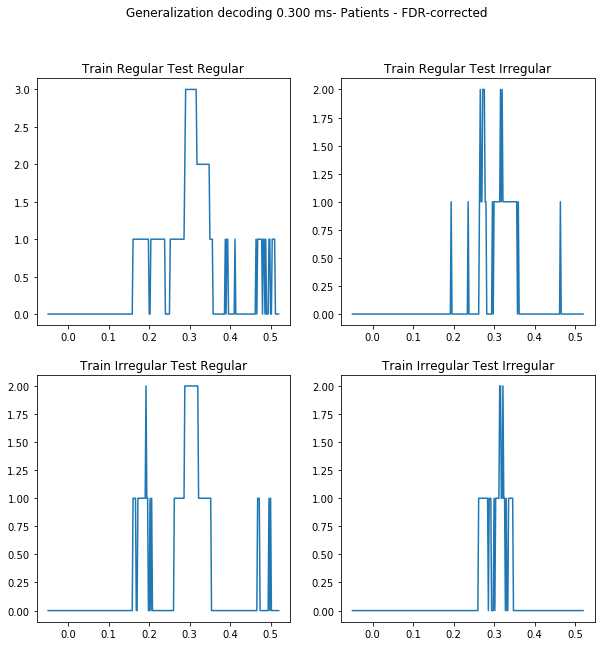

In [35]:
for curtp_ind in [125,150,175]:

    offdiag_sig_fdr_controls,_,_ = offdiagonal_group(controls_id,statspath,curtp_ind,doplots=True,timevec=timevec)
    offdiag_sig_fdr_patients,_,_ = offdiagonal_group(patients_id,statspath,curtp_ind,doplots=True,timevec=timevec)

    subtitles = ['Train Regular Test Regular',
                'Train Regular Test Irregular',
                'Train Irregular Test Regular',
                'Train Irregular Test Irregular']


    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_controls[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms - Controls - FDR-corrected' % timevec[curtp_ind])
    plt.show()


    plt.figure(figsize=(10,10))


    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_patients[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms- Patients - FDR-corrected' % timevec[curtp_ind])
    plt.show()


Step 3a - Across subjects statistics for controls 

In [78]:
for subj in controls_id:
    cursubj = os.path.join(statspath,subj)
    curpvals = np.load(cursubj)['proba'].mean(axis=1)
    

In [87]:
timepoints = np.array([ timevec[0],  timevec[-1],   timevec[0],  timevec[-1]])

In [91]:
curpvals.shape

(4, 2, 286, 286)

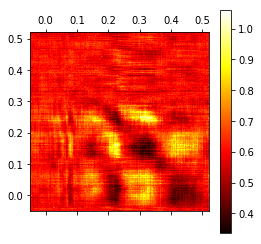

In [90]:
plt.matshow(-np.log10(curpvals[0][0]),extent=timepoints,cmap=plt.cm.hot)

plt.colorbar()

In [84]:
plt.imshow?

Step 3b - Across subjects statistics for patients 